Data Mining 2019/20

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [2]:
df = pd.read_csv('training.csv')

I tipi mi sembrano tutti giusti, considerando che degli attributi che sono int64 o float64, gli unici di cui ha senso calcolare la media sono tutti gli MMR, VehBCost, WarrantyCost, e volendo anche vehOdo, vehYear e vehAge. Gli altri son tutti o contatori (refId e BYRNO) o categorie (tutti gli altri)

In [3]:
df.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,58386.000000,58386.000000,58386.000000,58386.000000,55813.000000,58386.000000,58373.000000,58373.000000,58373.000000,58373.000000,58141.000000,58141.000000,58141.000000,58141.000000,58386.000000,58386.000000,58386.000000,58386.000000,58386.000000
mean,36567.888449,0.123454,2005.344637,4.174956,1.495566,71478.090518,6128.127953,7372.912699,8497.288558,9851.768061,6131.666655,7389.958652,8776.065118,10145.227034,26359.191519,58125.258195,6730.008335,0.025674,1276.105042
std,21092.254801,0.328961,1.733307,1.713833,0.520802,14591.224550,2456.632611,2715.506462,3151.106237,3378.839613,2432.171539,2682.310828,3086.373733,3304.637060,25804.795573,26146.806098,1762.075265,0.158162,598.885423
min,1.000000,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,18270.250000,0.000000,2004.000000,3.000000,1.000000,61785.000000,4273.000000,5409.000000,6279.000000,7501.000000,4275.000000,5415.000000,6538.000000,7788.000000,17212.000000,32124.000000,5430.000000,0.000000,837.000000
50%,36608.500000,0.000000,2005.000000,4.000000,1.000000,73359.000000,6097.000000,7308.000000,8448.000000,9798.000000,6063.000000,7311.000000,8733.000000,10103.000000,19662.000000,74135.000000,6700.000000,0.000000,1155.000000
75%,54811.500000,0.000000,2007.000000,5.000000,2.000000,82427.000000,7765.000000,9017.000000,10652.000000,12084.000000,7737.000000,9014.000000,10910.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,73014.000000,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,36485.000000,1.000000,7498.000000


SCARTEREI:
PRIMEUNIT,AUCGUART
Dobbiamo ricordarci, in caso in cui consegnassimo alcune di queste tabelle nel report, di NON usare tutti gli attributi come in questo caso ma filtrare solo quelli per cui i valori mostrati hanno senso


In [4]:
df.isnull().sum()

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  1911
SubModel                                 7
Color                                    7
Transmission                             8
WheelTypeID                           2573
WheelType                             2577
VehOdo                                   0
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice       13
MMRAcquisitionAuctionCleanPrice         13
MMRAcquisitionRetailAveragePrice        13
MMRAcquisitonRetailCleanPrice           13
MMRCurrentAuctionAveragePrice          245
MMRCurrentA

In [5]:
df.drop(columns=['RefId']).corr()

,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
IsBadBuy,1.000000,-0.156926,0.165325,-0.047693,0.082858,-0.105793,-0.099315,-0.084514,-0.080712,-0.106130,-0.101036,-0.100786,-0.097195,-0.059412,0.006393,-0.098132,-0.003969,0.050259
VehYear,-0.156926,1.000000,-0.958049,0.261366,-0.283569,0.582416,0.533807,0.582414,0.540206,0.591968,0.549345,0.599415,0.559579,0.281799,0.069976,0.349672,0.057316,-0.267739
VehicleAge,0.165325,-0.958049,1.000000,-0.252018,0.318778,-0.567106,-0.519897,-0.462299,-0.427526,-0.576914,-0.533646,-0.505322,-0.470640,-0.269907,-0.076617,-0.311903,-0.024659,0.257996
WheelTypeID,-0.047693,0.261366,-0.252018,1.000000,-0.212432,-0.094658,-0.129608,-0.071736,-0.101796,-0.086798,-0.120046,-0.072684,-0.101250,0.189817,0.007846,-0.160986,-0.011364,-0.133688
VehOdo,0.082858,-0.283569,0.318778,-0.212432,1.000000,-0.018381,0.023717,0.029107,0.061407,-0.030141,0.010755,0.013719,0.046070,-0.292230,-0.053547,-0.064436,0.030994,0.411273
MMRAcquisitionAuctionAveragePrice,-0.105793,0.582416,-0.567106,-0.094658,-0.018381,1.000000,0.990218,0.910185,0.909832,0.937482,0.931919,0.871220,0.870424,0.108806,0.047112,0.789354,0.038029,-0.049682
MMRAcquisitionAuctionCleanPrice,-0.099315,0.533807,-0.519897,-0.129608,0.023717,0.990218,1.000000,0.902339,0.917934,0.923144,0.931599,0.860055,0.870604,0.062818,0.041810,0.781123,0.037896,-0.019607
MMRAcquisitionRetailAveragePrice,-0.084514,0.582414,-0.462299,-0.071736,0.029107,0.910185,0.902339,1.000000,0.990085,0.851330,0.848776,0.912747,0.905523,0.107988,0.036402,0.745718,0.079767,-0.053507
MMRAcquisitonRetailCleanPrice,-0.080712,0.540206,-0.427526,-0.101796,0.061407,0.909832,0.917934,0.990085,1.000000,0.846393,0.854986,0.902680,0.906231,0.069857,0.032120,0.744622,0.076735,-0.026708
MMRCurrentAuctionAveragePrice,-0.106130,0.591968,-0.576914,-0.086798,-0.030141,0.937482,0.923144,0.851330,0.846393,1.000000,0.990244,0.915147,0.912305,0.112075,0.051706,0.778253,0.039513,-0.056893


Pandas è un bravo ragazzo, e ha eliminato di sua spontanea iniziativa PRIMEUNIT e AUCGUART. Ha anche tolto purchDate, auction, Make, Model, Trim, SubModel, Color, Transmission, WheelType (ha mantenuto l'id), Nationality, Size, TopThreeAmericanNames, VNST. 
- WarrantyCost e vehOdo: macchine con tanti km -> assicurazione costa tanto -> (forse) prob. bad buy?
C'è buona correlazione con tutti gli atttributi relativi al prezzo. Forse dobbiamo, più avanti, spendere un po' di tempo a cercare di cavare qualche variabile sensata da questi valori (che ne so, VehBCost/MMRAcquisitionAuctionAveragePrice e così via)

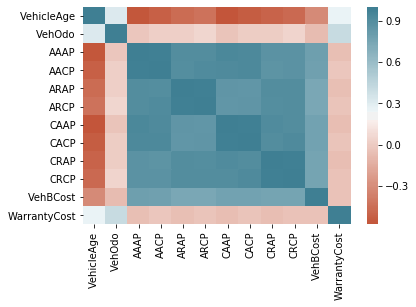

In [35]:
df.rename(columns={ 'MMRAcquisitionAuctionAveragePrice':'AAAP',
                    'MMRAcquisitionRetailAveragePrice':'ARAP',
                    'MMRCurrentAuctionAveragePrice':'CAAP',
                    'MMRCurrentRetailAveragePrice':'CRAP',
                    'MMRAcquisitionAuctionCleanPrice': 'AACP',
                    'MMRAcquisitonRetailCleanPrice': 'ARCP',
                    'MMRCurrentAuctionCleanPrice': 'CACP',
                    'MMRCurrentRetailCleanPrice': 'CRCP'
                  },inplace=True)

corr = df.drop(columns=['RefId',
        'VehYear',
        'IsBadBuy',
        'WheelTypeID',
        'BYRNO',
        'VNZIP1',
        'IsOnlineSale'],
        axis=1).corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.diverging_palette(20, 220, n=200),)

## Colonne rinominate con gli acronimi per cercare di capire qualcosa 
## +
## Rimosse tutte le colonne "CleanPrice"

Si può già notare come la colonna "VehicleAge" sia inversamente correlata (-0.6 circa) con il prezzo. 

Ciò ha molto senso dato che le auto 🚗 perdono valore con il passare degli anni. 😎

In [ ]:
fig = plt.figure(figsize=(15, 15)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
df.boxplot(column=['VehYear'])

plt.subplot2grid(fig_dims, (0, 1))
df.boxplot(column=['VehOdo'])

plt.subplot2grid(fig_dims, (1, 0))
df.boxplot(column=['VehBCost'])

plt.subplot2grid(fig_dims, (1, 1))
df.boxplot(column=['WarrantyCost'])

plt.subplot2grid(fig_dims, (2, 0))
df.boxplot(column=['AAAP'])

plt.subplot2grid(fig_dims, (2, 1))
df.boxplot(column=['CAAP'])

In [ ]:
pclass_xt = pd.crosstab(df['Transmission'], df['WheelType'])
pclass_xt

In [ ]:
pclass_xt.plot(kind='bar', stacked=True)

In [ ]:
fig = plt.figure(figsize=(15, 15)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
df['Auction'].value_counts().plot.pie(legend=True)

plt.subplot2grid(fig_dims, (0, 1))
df['Nationality'].value_counts().plot.pie(legend=True)

plt.subplot2grid(fig_dims, (1, 0))
df['Color'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (1, 1))
df['VNST'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (2, 0))
df['Size'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (2, 1))
df['Make'].value_counts().plot(kind='bar')

In [ ]:
df['BYRNO'].value_counts()

In [ ]:
df.apply(lambda x : 'refID'==326)